# Music Recommendation

In [2]:
!pip install catboost==1.0.3
!pip install gensim==4.1.0
!pip install --upgrade numpy

In [ ]:
%cd /content
!wget https://voudy-data.s3.eu-north-1.amazonaws.com/wsdm_data.tar.gz
!tar -xf /content/wsdm_data.tar.gz
!mkdir data
!mv -t data members.csv song_extra_info.csv songs.csv train.csv
!git clone -b hw2 https://github.com/Sushentsev/recommendation-systems
%cd recommendation-systems/
!mv /content/data /content/recommendation-systems/hw2

In [3]:
%cd /content/recommendation-systems/hw2

/content/recommendation-systems/hw2


In [30]:
import sys
sys.path.append("/content/recommendation-systems")
from load_data import *
from plot import *
from utils import *
from models import *
from embeddings import EmbeddingsBuilder
from create_features.song_features import create_song_features
from create_features.user_features import create_user_features
from catboost import CatBoostRanker, Pool, cv
from sklearn.metrics import roc_auc_score
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupKFold

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Подготовка данных

In [5]:
random_state = 42
data_dir = "./data/"

Сделаем признаки для песен. 

In [6]:
%%time
song_features_df = create_song_features(data_dir)

CPU times: user 1min 2s, sys: 2.23 s, total: 1min 5s
Wall time: 1min 4s


In [7]:
song_features_df.head(3)

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language,artist_name_count,composer_count,lyricists_count,isrc_year,genres_count
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0,1,1,1,2014,1
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0,1,3,1,-1,1
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,<UNK>,<UNK>,31.0,1,0,0,-1,0


Сделаем признаки для пользователей. 

In [8]:
%%time
user_features_df = create_user_features(data_dir)

CPU times: user 460 ms, sys: 4.05 ms, total: 464 ms
Wall time: 465 ms


In [9]:
user_features_df.head(3)

,msno,city,gender,registered_via,bd_category,registration_init_year,expiration_date_year
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,<UNK>,7,<UNK>,2011,2017
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,<UNK>,7,<UNK>,2015,2017
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,<UNK>,4,<UNK>,2016,2017


Загрузим тренировочную выборку и добавим существующие признаки. 

In [10]:
train_df = load_train(data_dir + "train.csv")
train_df.head(3)

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1


In [11]:
train_df = train_df.merge(song_features_df, on="song_id", how="left")
train_df = train_df.merge(user_features_df, on="msno", how="left")
train_df.head(3)

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,lyricist,language,artist_name_count,composer_count,lyricists_count,isrc_year,genres_count,city,gender,registered_via,bd_category,registration_init_year,expiration_date_year
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,206471.0,359,Bastille,Dan Smith| Mark Crew,<UNK>,52.0,1.0,2.0,0.0,2016,0.0,1,<UNK>,7,<UNK>,2012,2017
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,284584.0,1259,Various Artists,<UNK>,<UNK>,52.0,1.0,0.0,0.0,1999,0.0,13,female,9,young,2011,2017
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,225396.0,1259,Nas,N. Jones、W. Adams、J. Lordan、D. Ingle,<UNK>,52.0,1.0,1.0,0.0,2006,0.0,13,female,9,young,2011,2017


In [12]:
train_df.source_system_tab = train_df.source_system_tab.cat.add_categories("<UNK>").fillna(value="<UNK>")
train_df.source_screen_name = train_df.source_screen_name.cat.add_categories("<UNK>").fillna(value="<UNK>")
train_df.source_type = train_df.source_type.cat.add_categories("<UNK>").fillna(value="<UNK>")

train_df.msno = train_df.msno.astype("category")
train_df.song_id = train_df.song_id.astype("category")

In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7377418 entries, 0 to 7377417
Data columns (total 23 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   msno                    category
 1   song_id                 category
 2   source_system_tab       category
 3   source_screen_name      category
 4   source_type             category
 5   target                  uint8   
 6   song_length             float64 
 7   genre_ids               category
 8   artist_name             category
 9   composer                category
 10  lyricist                category
 11  language                category
 12  artist_name_count       float64 
 13  composer_count          float64 
 14  lyricists_count         float64 
 15  isrc_year               category
 16  genres_count            float64 
 17  city                    category
 18  gender                  category
 19  registered_via          category
 20  bd_category             category
 21  registra

In [14]:
na_mask = train_df.isna().any(axis=1)
print(f"Количество записей, для которых не нашлось пользователя или песни: {sum(na_mask)}")

Количество записей, для которых не нашлось пользователя или песни: 114


Их оказалось не так много, уберем из нашего набора данных. 

In [15]:
train_df = train_df[~na_mask]

Так как **CatBoost** на CPU обучается достаточно долго (больше часа), то было решено обучать на GPU. Однако GPU не поддерживает группы больше 1023, поэтому тренировочный набор данных был уменьшен. При этом, желательно сохранить порядок записей.

In [16]:
train_reduced_df = train_df.groupby("msno").head(1023).reset_index(drop=True)
train_reduced_df.target.value_counts()

1    3564182
0    3451109
Name: target, dtype: int64

По крайней мере получили равномерное распределение по целевой переменной, будем считать, что это ок ;)

## Задание 1

Построить рекомендации для каждого пользователя, произвести оценку качества с помощью 5-fold CV с метриками NDCG, ROC AUC.

При разработке признаков я умеренно не стал брать признаки, полученные с помощью матричных факторизаций, чтобы потом добавить неклассические эмбеддинги, полученные в задании 2. 

В качестве модели машинного обучения я решил использовать **CatBoost**, так как она хорошо работает с категориальными признаками. 

In [37]:
cat_columns = train_reduced_df.select_dtypes(include=["category"]).columns.to_numpy()
data = train_reduced_df.sort_values(by="msno")

In [28]:
params = {
    "loss_function": "YetiRank", 
    "iterations": 150, 
    "custom_metric": ["NDCG", "QueryAUC:type=Ranking"], 
    "random_seed": random_state, 
    "metric_period": 10,
    "task_type": "GPU"
}

In [30]:
group_kfold = GroupKFold(n_splits=5)

X = data.drop("target", axis=1)
y = data.target.to_numpy()
groups = data.msno.cat.codes.to_numpy()

scores = []
for train_index, test_index in group_kfold.split(X, y, groups):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    groups_train, groups_test = groups[train_index], groups[test_index]

    train_pool = Pool(data=X_train, label=y_train, group_id=groups_train, 
                      cat_features=cat_columns, has_header=True)
    test_pool = Pool(data=X_test, label=y_test, group_id=groups_test, 
                     cat_features=cat_columns, has_header=True)
    
    model = CatBoostRanker(**params)
    model.fit(train_pool, eval_set=test_pool)
    scores.append(model.get_evals_result())

Groupwise loss function. OneHotMaxSize set to 10


Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric QueryAUC:type=Ranking is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.5618024	best: 0.5618024 (0)	total: 2.02s	remaining: 5m
10:	test: 0.6339235	best: 0.6339235 (10)	total: 14.8s	remaining: 3m 6s
20:	test: 0.7376157	best: 0.7376157 (20)	total: 27.6s	remaining: 2m 49s
30:	test: 0.7404175	best: 0.7404175 (30)	total: 40.4s	remaining: 2m 35s
40:	test: 0.7409741	best: 0.7409741 (40)	total: 53.3s	remaining: 2m 21s
50:	test: 0.7409731	best: 0.7409741 (40)	total: 1m 6s	remaining: 2m 8s
60:	test: 0.7424382	best: 0.7424382 (60)	total: 1m 18s	remaining: 1m 55s
70:	test: 0.7462509	best: 0.7462509 (70)	total: 1m 31s	remaining: 1m 42s
80:	test: 0.7471724	best: 0.7471724 (80)	total: 1m 44s	remaining: 1m 29s
90:	test: 0.7581773	best: 0.7581773 (90)	total: 1m 57s	remaining: 1m 16s
100:	test: 0.7583847	best: 0.7583847 (100)	total: 2m 10s	remaining: 1m 3s
110:	test: 0.7591868	best: 0.7591868 (110)	total: 2m 23s	remaining: 50.4s
120:	test: 0.7617622	best: 0.7617622 (120)	total: 2m 36s	remaining: 37.5s
130:	test: 0.7615449	best: 0.7617622 (120)	total: 2m 49s	remai

Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric QueryAUC:type=Ranking is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.6142657	best: 0.6142657 (0)	total: 2.02s	remaining: 5m 1s
10:	test: 0.6500847	best: 0.6500847 (10)	total: 14.7s	remaining: 3m 6s
20:	test: 0.6508341	best: 0.6508341 (20)	total: 27.5s	remaining: 2m 48s
30:	test: 0.7118984	best: 0.7118984 (30)	total: 40.2s	remaining: 2m 34s
40:	test: 0.7121956	best: 0.7121956 (40)	total: 53s	remaining: 2m 20s
50:	test: 0.7129219	best: 0.7129219 (50)	total: 1m 5s	remaining: 2m 7s
60:	test: 0.7165660	best: 0.7165660 (60)	total: 1m 18s	remaining: 1m 54s
70:	test: 0.7188705	best: 0.7188705 (70)	total: 1m 31s	remaining: 1m 41s
80:	test: 0.7493500	best: 0.7493500 (80)	total: 1m 44s	remaining: 1m 28s
90:	test: 0.7513771	best: 0.7513771 (90)	total: 1m 57s	remaining: 1m 15s
100:	test: 0.7508930	best: 0.7513771 (90)	total: 2m 9s	remaining: 1m 3s
110:	test: 0.7509688	best: 0.7513771 (90)	total: 2m 22s	remaining: 50.2s
120:	test: 0.7690536	best: 0.7690536 (120)	total: 2m 35s	remaining: 37.3s
130:	test: 0.7709274	best: 0.7709274 (130)	total: 2m 48s	remaini

Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric QueryAUC:type=Ranking is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.6336347	best: 0.6336347 (0)	total: 2s	remaining: 4m 58s
10:	test: 0.6661573	best: 0.6661573 (10)	total: 14.7s	remaining: 3m 6s
20:	test: 0.6664079	best: 0.6664079 (20)	total: 27.5s	remaining: 2m 48s
30:	test: 0.6708405	best: 0.6708405 (30)	total: 40.2s	remaining: 2m 34s
40:	test: 0.7292888	best: 0.7292888 (40)	total: 53s	remaining: 2m 20s
50:	test: 0.7297467	best: 0.7297467 (50)	total: 1m 5s	remaining: 2m 7s
60:	test: 0.7300793	best: 0.7300793 (60)	total: 1m 18s	remaining: 1m 54s
70:	test: 0.7297417	best: 0.7300793 (60)	total: 1m 31s	remaining: 1m 41s
80:	test: 0.7511253	best: 0.7511253 (80)	total: 1m 44s	remaining: 1m 28s
90:	test: 0.7543886	best: 0.7543886 (90)	total: 1m 57s	remaining: 1m 15s
100:	test: 0.7540817	best: 0.7543886 (90)	total: 2m 9s	remaining: 1m 3s
110:	test: 0.7705828	best: 0.7705828 (110)	total: 2m 22s	remaining: 50.2s
120:	test: 0.7711934	best: 0.7711934 (120)	total: 2m 35s	remaining: 37.3s
130:	test: 0.7734734	best: 0.7734734 (130)	total: 2m 48s	remainin

Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric QueryAUC:type=Ranking is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.6452793	best: 0.6452793 (0)	total: 1.99s	remaining: 4m 57s
10:	test: 0.6689070	best: 0.6689070 (10)	total: 14.8s	remaining: 3m 6s
20:	test: 0.6692909	best: 0.6692909 (20)	total: 27.5s	remaining: 2m 49s
30:	test: 0.7243135	best: 0.7243135 (30)	total: 40.4s	remaining: 2m 34s
40:	test: 0.7241160	best: 0.7243135 (30)	total: 53.2s	remaining: 2m 21s
50:	test: 0.7240036	best: 0.7243135 (30)	total: 1m 6s	remaining: 2m 8s
60:	test: 0.7247612	best: 0.7247612 (60)	total: 1m 18s	remaining: 1m 55s
70:	test: 0.7252607	best: 0.7252607 (70)	total: 1m 31s	remaining: 1m 42s
80:	test: 0.7263252	best: 0.7263252 (80)	total: 1m 44s	remaining: 1m 29s
90:	test: 0.7347117	best: 0.7347117 (90)	total: 1m 57s	remaining: 1m 16s
100:	test: 0.7343139	best: 0.7347117 (90)	total: 2m 10s	remaining: 1m 3s
110:	test: 0.7519142	best: 0.7519142 (110)	total: 2m 23s	remaining: 50.3s
120:	test: 0.7534374	best: 0.7534374 (120)	total: 2m 36s	remaining: 37.4s
130:	test: 0.7677018	best: 0.7677018 (130)	total: 2m 49s	re

Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric QueryAUC:type=Ranking is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.6200022	best: 0.6200022 (0)	total: 2.04s	remaining: 5m 3s
10:	test: 0.6618695	best: 0.6618695 (10)	total: 14.9s	remaining: 3m 7s
20:	test: 0.6623503	best: 0.6623503 (20)	total: 27.7s	remaining: 2m 50s
30:	test: 0.7207179	best: 0.7207179 (30)	total: 40.6s	remaining: 2m 35s
40:	test: 0.7222481	best: 0.7222481 (40)	total: 53.4s	remaining: 2m 21s
50:	test: 0.7223659	best: 0.7223659 (50)	total: 1m 6s	remaining: 2m 8s
60:	test: 0.7232085	best: 0.7232085 (60)	total: 1m 19s	remaining: 1m 55s
70:	test: 0.7272198	best: 0.7272198 (70)	total: 1m 31s	remaining: 1m 42s
80:	test: 0.7520644	best: 0.7520644 (80)	total: 1m 44s	remaining: 1m 29s
90:	test: 0.7519532	best: 0.7520644 (80)	total: 1m 57s	remaining: 1m 16s
100:	test: 0.7530338	best: 0.7530338 (100)	total: 2m 10s	remaining: 1m 3s
110:	test: 0.7656076	best: 0.7656076 (110)	total: 2m 23s	remaining: 50.5s
120:	test: 0.7653928	best: 0.7656076 (110)	total: 2m 36s	remaining: 37.6s
130:	test: 0.7657673	best: 0.7657673 (130)	total: 2m 49s	re

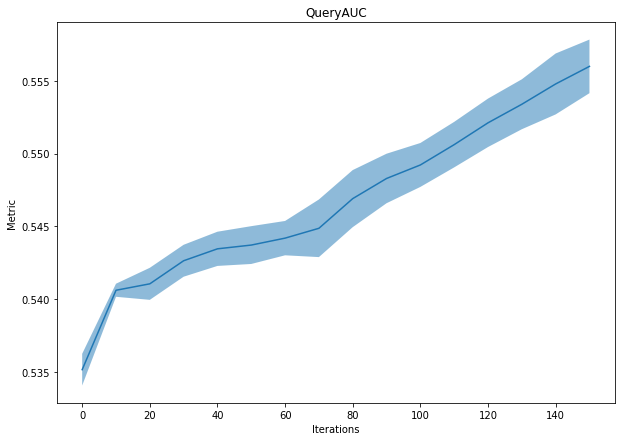

In [50]:
plot_scores(scores, "QueryAUC:type=Ranking", "QueryAUC")

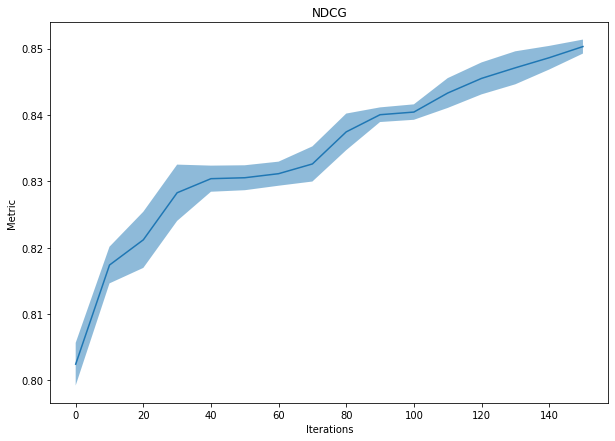

In [53]:
plot_scores(scores, "NDCG:type=Base", "NDCG")

## Задание 2

Построить неклассические эмбеддинги и исследовать их полезность. 

In [ ]:
%%time
embeddings = EmbeddingsBuilder(embedding_dim=100, random_state=random_state)
embeddings = embeddings.fit(train_df)
save_pickle(embeddings, "embeddings.pkl")

In [20]:
embeddings = load_pickle("embeddings.pkl")

Посмотрим на похожие песни и пользователей, визуализировав их с помощью PCA.

Посмотрим на похожие песни и пользователей, визуализировав их с помощью PCA. Будем называть песни похожими, если они принадлежат к одному жанру.

In [21]:
song_features_df.groupby(["genre_ids"]).count().sort_values(by="song_id", ascending=False).head()

,song_id,song_length,artist_name,composer,lyricist,language,artist_name_count,composer_count,lyricists_count,isrc_year,genres_count
genre_ids,,,,,,,,,,,
465,567911,567911,567911,567911,567911,567911,567911,567911,567911,567911,567911
958,176349,176349,176349,176349,176349,176349,176349,176349,176349,176349,176349
2022,168870,168870,168870,168870,168870,168870,168870,168870,168870,168870,168870
1609,166457,166457,166457,166457,166457,166457,166457,166457,166457,166457,166457
2122,139938,139938,139938,139938,139938,139938,139938,139938,139938,139938,139938


In [22]:
genres_ids = ["958", "2022", "1609", "2122"]
sim_songs_df = song_features_df[song_features_df.genre_ids.isin(genres_ids)]

songs = sim_songs_df.song_id.to_numpy()
genres = sim_songs_df.genre_ids.to_numpy()
has_embedding = np.array([embeddings.has_item(song) for song in songs])

songs = songs[has_embedding]
genres = genres[has_embedding]

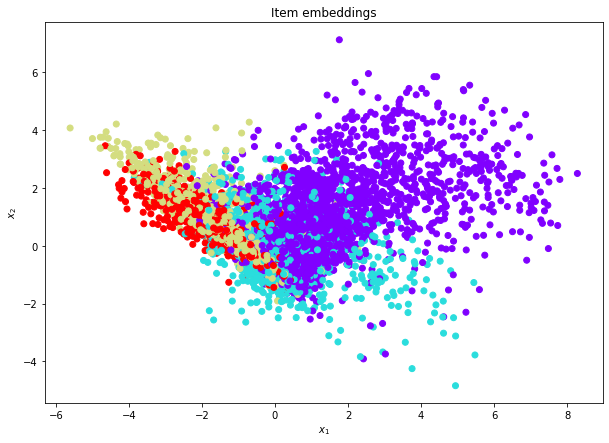

In [23]:
plot_similar(embeddings.get_item_embeddings(songs), genres, "Item embeddings")

Можно видеть, что есть небольшие группы.

Теперь измерим качество получившейся модели.

In [32]:
emb_model = EmbeddingBasedModel(embeddings)

In [41]:
group_kfold = GroupKFold(n_splits=5)

cat_columns = train_reduced_df.select_dtypes(include=["category"]).columns.to_numpy()
data = train_reduced_df.sort_values(by="msno")

X = data.song_id.to_numpy()
y = data.target.to_numpy()
groups = data.msno.to_numpy()

scores = []
for _, test_index in group_kfold.split(X, y, groups):
    X_test = X[test_index]
    y_test = y[test_index]
    groups_test = groups[test_index]

    for group_id in np.unique(groups_test): 
        mask = group_id == groups_test
        ans = emb_model.rank_scores(group_id, X_test[mask])
        print(ans)
        break
        # TODO

    break
    # TODO

[ 2.00331032e+01  0.00000000e+00  2.03408247e+01  0.00000000e+00
  3.12886511e+00  5.55073476e+00  1.37800889e+01  5.56097448e+00
  9.06846121e+00  1.11468761e+00  1.34749653e+01  1.29029731e+01
  1.42353814e+01  8.98532351e-01  1.75961534e+01  1.66149396e+00
  1.54158577e+01  1.32337233e+01  1.26306980e+01  1.25804993e+01
  1.57936671e+01  3.90761379e-01  6.09017948e+00  4.24178920e+00
  2.40089474e+00  1.61734843e+01  1.78694498e+01  4.85760825e-01
  1.63760627e-01  0.00000000e+00  1.07574768e+00  1.04875270e+00
  2.22724591e+01  1.90969431e+01  0.00000000e+00  4.00092856e+00
  1.36322788e+01  9.05081960e+00  1.59488800e+01  9.07652623e+00
  6.78822195e+00  2.25054449e+00  1.64759248e+01  8.25694049e+00
  0.00000000e+00  1.24347984e+01  9.75708561e-01  1.39099402e+01
  1.97290205e+01  1.79136326e+01  1.98359068e+01  1.33548408e+01
  1.95369219e+01  1.62572442e+01  1.14544254e+00  2.98654965e-01
  1.39710559e+01  1.84404403e+01  1.26635333e+00  1.17209232e+01
  1.14292997e+01  1.53941